# Deep Dive 4: Survival Rates

**Question**: How do Dutch startups survive compared to benchmarks? Where do they die?

**Key metrics**:
- Stage survival (Seed → A → B → Exit)
- Failure rates by stage
- Survival by sector
- The "Valley of Death"

---

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

COLORS = {
    'nl': '#D55E00', 'usa': '#0072B2', 'israel': '#009E73',
    'uk': '#56B4E9', 'germany': '#E69F00', 'france': '#CC79A7',
    'gray': '#999999', 'success': '#009E73', 'failure': '#D55E00'
}

def tufte_style(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#666666')
    ax.spines['bottom'].set_color('#666666')
    ax.tick_params(colors='#666666')
    return ax

os.makedirs('figures/deep_dive_4', exist_ok=True)

# Load and clean
df = pd.read_csv('/Users/coendewith/techleap/investments_VC.csv', encoding='latin-1')
df.columns = df.columns.str.strip()
df['country_code'] = df['country_code'].str.strip()
df['market'] = df['market'].str.strip()

df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')
df = df[df['first_funding_at'].notna()]
df = df[(df['first_funding_at'].dt.year >= 2005) & (df['first_funding_at'].dt.year <= 2014)]

# Funding columns
round_cols = ['seed', 'round_A', 'round_B', 'round_C', 'round_D']
for col in round_cols + ['funding_rounds']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

df['had_seed'] = df['seed'] > 0
df['had_series_a'] = df['round_A'] > 0
df['had_series_b'] = df['round_B'] > 0
df['had_series_c'] = df['round_C'] > 0
df['exited'] = df['status'].isin(['acquired', 'ipo'])
df['failed'] = df['status'] == 'closed'
df['operating'] = df['status'] == 'operating'

COUNTRIES = {'NLD': 'Netherlands', 'USA': 'USA', 'ISR': 'Israel', 
             'GBR': 'UK', 'DEU': 'Germany', 'FRA': 'France'}

benchmark = df[df['country_code'].isin(COUNTRIES.keys())].copy()
benchmark['country'] = benchmark['country_code'].map(COUNTRIES)

print(f"Companies: {len(benchmark):,}")

Companies: 33,364


---
## 4.1 Overall Survival Rates by Country

In [6]:
# Status distribution by country
status_by_country = benchmark.groupby('country')['status'].value_counts(normalize=True).unstack() * 100
status_by_country = status_by_country.fillna(0)

print("STATUS DISTRIBUTION BY COUNTRY (%)")
print(status_by_country.round(1))

STATUS DISTRIBUTION BY COUNTRY (%)
status       acquired  closed  operating
country                                 
France            4.9     5.6       89.4
Germany           7.2     4.8       88.0
Israel            8.5     7.0       84.5
Netherlands       4.5     4.5       91.0
UK                5.1     6.0       89.0
USA               9.1     5.2       85.7


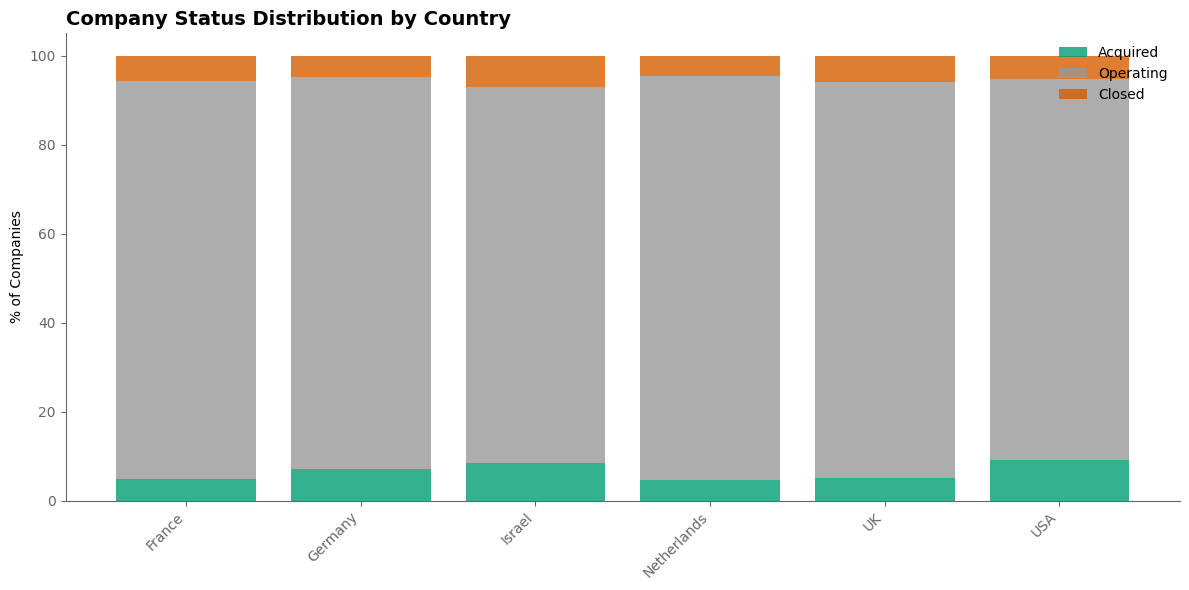

In [7]:
# Visualization: Status distribution
fig, ax = plt.subplots(figsize=(12, 6))
tufte_style(ax)

# Stacked bar
status_order = ['acquired', 'ipo', 'operating', 'closed']
status_colors = {'acquired': COLORS['success'], 'ipo': COLORS['israel'], 
                 'operating': COLORS['gray'], 'closed': COLORS['failure']}

countries = status_by_country.index.tolist()
x = np.arange(len(countries))
bottom = np.zeros(len(countries))

for status in status_order:
    if status in status_by_country.columns:
        values = status_by_country[status].values
        ax.bar(x, values, bottom=bottom, label=status.capitalize(), color=status_colors[status], alpha=0.8)
        bottom += values

ax.set_xticks(x)
ax.set_xticklabels(countries, rotation=45, ha='right')
ax.set_ylabel('% of Companies')
ax.set_title('Company Status Distribution by Country', fontsize=14, fontweight='bold', loc='left')
ax.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.savefig('figures/deep_dive_4/status_by_country.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4.2 Funding Stage Survival (Funnel Analysis)

In [8]:
# Calculate funnel by country
def calculate_funnel(country_code):
    subset = df[df['country_code'] == country_code]
    n = len(subset)
    if n == 0:
        return None
    
    return {
        'country': COUNTRIES.get(country_code, country_code),
        'Funded': 100,
        'Seed': subset['had_seed'].sum() / n * 100,
        'Series A': subset['had_series_a'].sum() / n * 100,
        'Series B': subset['had_series_b'].sum() / n * 100,
        'Series C': subset['had_series_c'].sum() / n * 100,
        'Exited': subset['exited'].sum() / n * 100,
        'n': n
    }

funnel_data = [calculate_funnel(c) for c in COUNTRIES.keys()]
funnel_df = pd.DataFrame(funnel_data).set_index('country')

print("FUNDING FUNNEL BY COUNTRY (% reaching each stage)")
print(funnel_df.round(1))

FUNDING FUNNEL BY COUNTRY (% reaching each stage)
             Funded  Seed  Series A  Series B  Series C  Exited      n
country                                                               
Netherlands     100  31.8      11.5       7.2       2.0     4.3    305
USA             100  24.9      19.9      12.6       7.0     8.9  28006
Israel          100  27.0      25.2      16.0       7.3     8.5    674
UK              100  30.3      13.4       7.6       3.4     5.0   2580
Germany         100  25.1      14.0       9.1       3.8     7.0    947
France          100  25.8      25.4      13.6       5.3     4.8    852


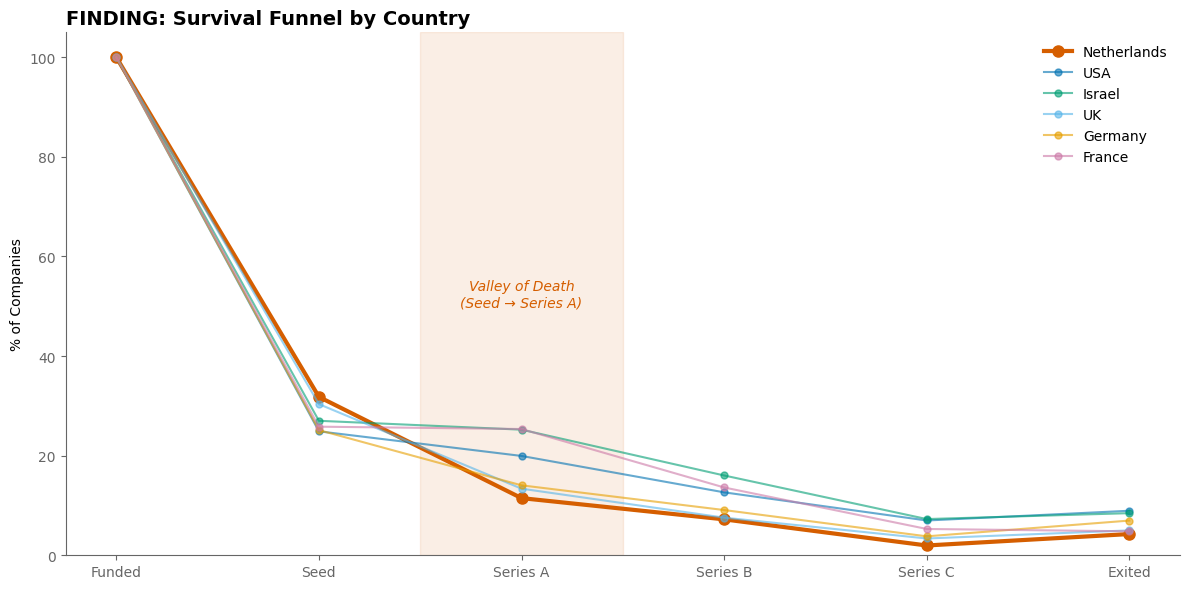

In [9]:
# Visualization: Survival funnel
fig, ax = plt.subplots(figsize=(12, 6))
tufte_style(ax)

stages = ['Funded', 'Seed', 'Series A', 'Series B', 'Series C', 'Exited']
x = np.arange(len(stages))

country_colors = {'Netherlands': COLORS['nl'], 'USA': COLORS['usa'], 'Israel': COLORS['israel'],
                  'UK': COLORS['uk'], 'Germany': COLORS['germany'], 'France': COLORS['france']}

for country in funnel_df.index:
    values = [funnel_df.loc[country, s] for s in stages]
    linewidth = 3 if country == 'Netherlands' else 1.5
    alpha = 1.0 if country == 'Netherlands' else 0.6
    ax.plot(x, values, marker='o', label=country, color=country_colors[country],
            linewidth=linewidth, alpha=alpha, markersize=8 if country == 'Netherlands' else 5)

ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.set_ylabel('% of Companies')
ax.set_title('FINDING: Survival Funnel by Country', fontsize=14, fontweight='bold', loc='left')
ax.legend(loc='upper right', frameon=False)
ax.set_ylim(0, 105)

# Highlight the "Valley of Death"
ax.axvspan(1.5, 2.5, alpha=0.1, color=COLORS['failure'])
ax.text(2, 50, 'Valley of Death\n(Seed → Series A)', ha='center', fontsize=10, 
        color=COLORS['failure'], style='italic')

plt.tight_layout()
plt.savefig('figures/deep_dive_4/survival_funnel.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# Calculate stage-to-stage conversion rates
def conversion_rates(country_code):
    subset = df[df['country_code'] == country_code]
    
    with_seed = subset[subset['had_seed']]
    with_a = subset[subset['had_series_a']]
    with_b = subset[subset['had_series_b']]
    
    seed_to_a = with_seed['had_series_a'].sum() / len(with_seed) * 100 if len(with_seed) > 0 else 0
    a_to_b = with_a['had_series_b'].sum() / len(with_a) * 100 if len(with_a) > 0 else 0
    b_to_exit = with_b['exited'].sum() / len(with_b) * 100 if len(with_b) > 0 else 0
    
    return {
        'country': COUNTRIES.get(country_code, country_code),
        'Seed→A': seed_to_a,
        'A→B': a_to_b,
        'B→Exit': b_to_exit
    }

conv_data = [conversion_rates(c) for c in COUNTRIES.keys()]
conv_df = pd.DataFrame(conv_data).set_index('country')

print("STAGE-TO-STAGE CONVERSION RATES (%)")
print(conv_df.round(1))

STAGE-TO-STAGE CONVERSION RATES (%)
             Seed→A   A→B  B→Exit
country                          
Netherlands     6.2  22.9    18.2
USA            15.8  37.7    19.5
Israel         21.4  32.9    15.7
UK              8.0  27.0    13.3
Germany        11.8  20.3     8.1
France          9.5  21.3     6.0


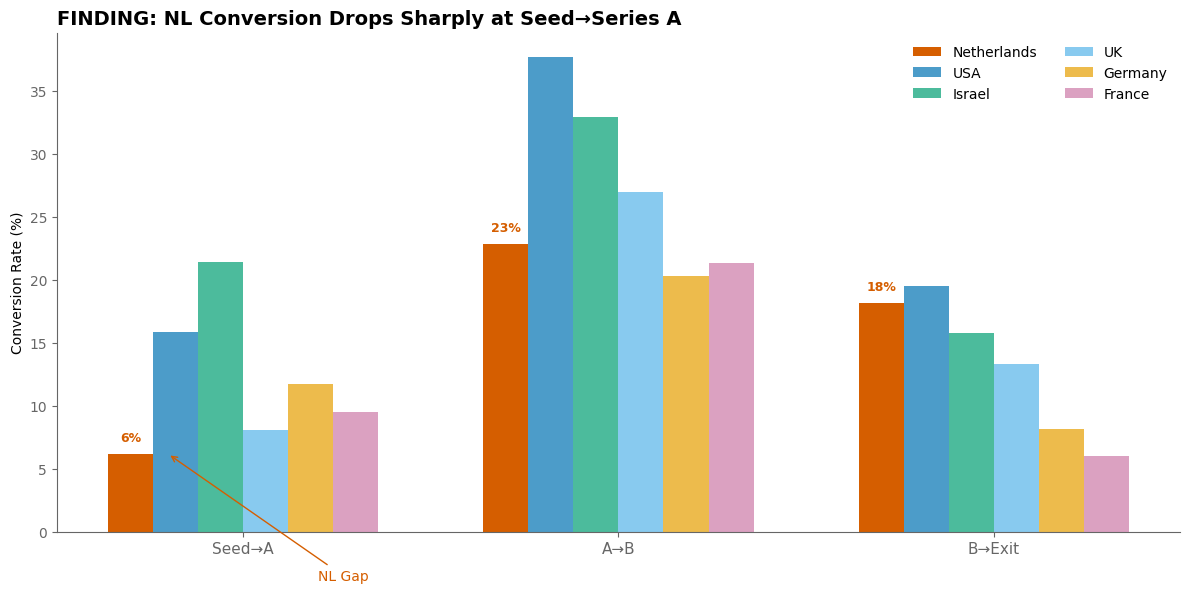

In [11]:
# Visualization: Conversion rates
fig, ax = plt.subplots(figsize=(12, 6))
tufte_style(ax)

transitions = ['Seed→A', 'A→B', 'B→Exit']
x = np.arange(len(transitions))
width = 0.12

for i, country in enumerate(conv_df.index):
    values = conv_df.loc[country].values
    color = country_colors[country]
    alpha = 1.0 if country == 'Netherlands' else 0.7
    bars = ax.bar(x + i*width, values, width, label=country, color=color, alpha=alpha)
    
    if country == 'Netherlands':
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{val:.0f}%', ha='center', fontsize=9, fontweight='bold', color=COLORS['nl'])

ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(transitions, fontsize=11)
ax.set_ylabel('Conversion Rate (%)')
ax.set_title('FINDING: NL Conversion Drops Sharply at Seed→Series A', fontsize=14, fontweight='bold', loc='left')
ax.legend(loc='upper right', ncol=2, frameon=False)

# Highlight the gap
ax.annotate('NL Gap', xy=(0.1, conv_df.loc['Netherlands', 'Seed→A']),
            xytext=(0.5, conv_df.loc['Netherlands', 'Seed→A'] - 10),
            fontsize=10, color=COLORS['nl'],
            arrowprops=dict(arrowstyle='->', color=COLORS['nl']))

plt.tight_layout()
plt.savefig('figures/deep_dive_4/conversion_rates.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4.3 Survival by Sector

In [12]:
# Sector survival rates
nl = benchmark[benchmark['country'] == 'Netherlands']
top_nl_sectors = nl['market'].value_counts().head(10).index.tolist()

sector_survival = []
for sector in top_nl_sectors:
    subset = nl[nl['market'] == sector]
    n = len(subset)
    if n < 3:
        continue
    
    sector_survival.append({
        'sector': sector,
        'n': n,
        'exit_rate': subset['exited'].mean() * 100,
        'fail_rate': subset['failed'].mean() * 100,
        'operating_rate': subset['operating'].mean() * 100,
        'avg_rounds': subset['funding_rounds'].mean()
    })

sector_df = pd.DataFrame(sector_survival).sort_values('exit_rate', ascending=False)
print("NL SECTOR SURVIVAL RATES:")
print(sector_df.round(1).to_string(index=False))

NL SECTOR SURVIVAL RATES:
             sector  n  exit_rate  fail_rate  operating_rate  avg_rounds
        Health Care  7       42.9        0.0            57.1         1.7
       Social Media 11        9.1        9.1            72.7         1.4
      Biotechnology 26        7.7        0.0            88.5         1.6
Hardware + Software 14        7.1        0.0            92.9         1.6
           Software 17        5.9        0.0            88.2         1.1
   Clean Technology 11        0.0        0.0           100.0         1.7
              Games  9        0.0        0.0           100.0         1.1
Enterprise Software  8        0.0       12.5            87.5         2.2
          Education  8        0.0        0.0            87.5         1.4
             Mobile  7        0.0        0.0            85.7         1.7


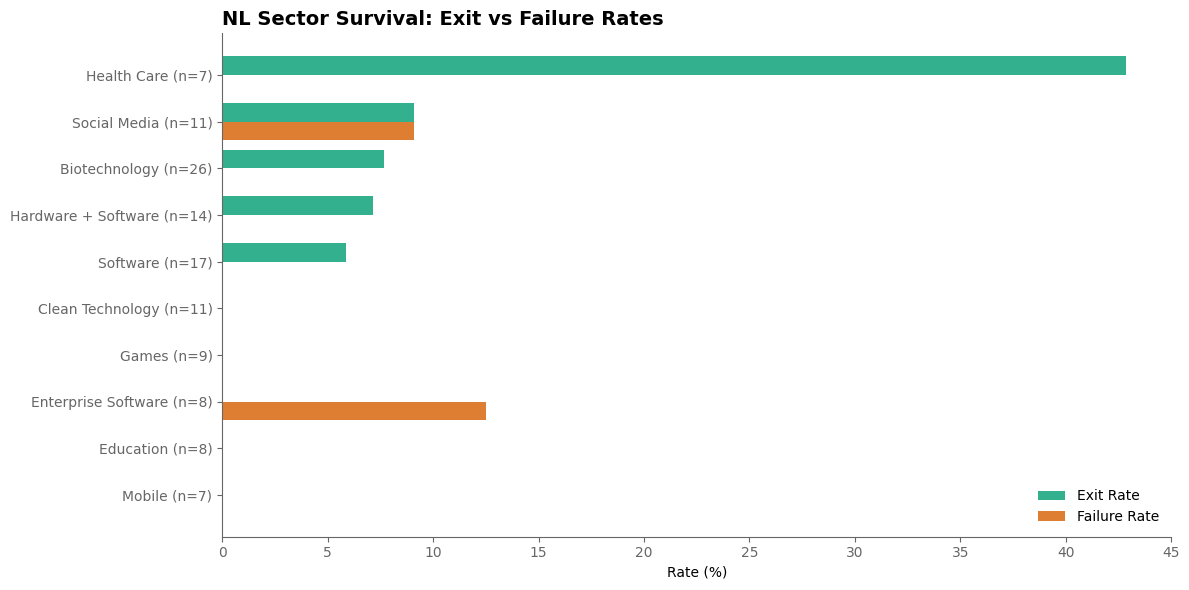

In [13]:
# Visualization: Sector survival
fig, ax = plt.subplots(figsize=(12, 6))
tufte_style(ax)

sectors = sector_df['sector'].tolist()
exit_rates = sector_df['exit_rate'].values
fail_rates = sector_df['fail_rate'].values
ns = sector_df['n'].values

x = np.arange(len(sectors))
ax.barh(x - 0.2, exit_rates, 0.4, label='Exit Rate', color=COLORS['success'], alpha=0.8)
ax.barh(x + 0.2, fail_rates, 0.4, label='Failure Rate', color=COLORS['failure'], alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels([f"{s} (n={n})" for s, n in zip(sectors, ns)])
ax.set_xlabel('Rate (%)')
ax.set_title('NL Sector Survival: Exit vs Failure Rates', fontsize=14, fontweight='bold', loc='left')
ax.legend(loc='lower right', frameon=False)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('figures/deep_dive_4/nl_sector_survival.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4.4 Survival by Number of Rounds

In [14]:
# Survival by funding rounds
def survival_by_rounds(country_code):
    subset = df[df['country_code'] == country_code]
    results = []
    
    for rounds in range(1, 6):
        round_subset = subset[subset['funding_rounds'] >= rounds]
        if len(round_subset) < 10:
            continue
        results.append({
            'rounds': f'{rounds}+ rounds',
            'exit_rate': round_subset['exited'].mean() * 100,
            'fail_rate': round_subset['failed'].mean() * 100,
            'n': len(round_subset)
        })
    
    return results

# Calculate for NL and USA
nl_rounds = pd.DataFrame(survival_by_rounds('NLD'))
us_rounds = pd.DataFrame(survival_by_rounds('USA'))

print("NL SURVIVAL BY FUNDING ROUNDS:")
print(nl_rounds.round(1))
print("\nUSA SURVIVAL BY FUNDING ROUNDS:")
print(us_rounds.round(1))

NL SURVIVAL BY FUNDING ROUNDS:
      rounds  exit_rate  fail_rate    n
0  1+ rounds        4.3        4.3  305
1  2+ rounds        8.0        1.1   88
2  3+ rounds        9.7        0.0   31
3  4+ rounds        0.0        0.0   10

USA SURVIVAL BY FUNDING ROUNDS:
      rounds  exit_rate  fail_rate      n
0  1+ rounds        8.9        5.1  28006
1  2+ rounds       11.9        4.0  11427
2  3+ rounds       12.3        2.9   5876
3  4+ rounds       10.9        2.7   3167
4  5+ rounds        9.3        2.3   1682


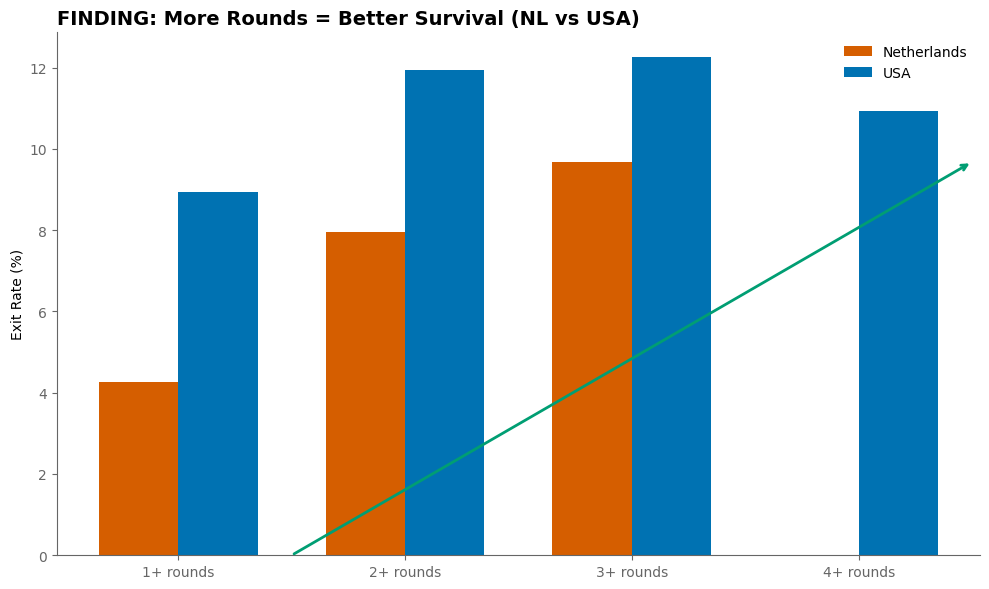

In [15]:
# Visualization: Rounds vs Survival
fig, ax = plt.subplots(figsize=(10, 6))
tufte_style(ax)

if len(nl_rounds) > 0 and len(us_rounds) > 0:
    x = np.arange(len(nl_rounds))
    width = 0.35
    
    ax.bar(x - width/2, nl_rounds['exit_rate'], width, label='Netherlands', color=COLORS['nl'])
    ax.bar(x + width/2, us_rounds['exit_rate'].values[:len(nl_rounds)], width, label='USA', color=COLORS['usa'])
    
    ax.set_xticks(x)
    ax.set_xticklabels(nl_rounds['rounds'])
    ax.set_ylabel('Exit Rate (%)')
    ax.set_title('FINDING: More Rounds = Better Survival (NL vs USA)', fontsize=14, fontweight='bold', loc='left')
    ax.legend(frameon=False)
    
    # Add trend line
    ax.annotate('', xy=(len(x)-0.5, nl_rounds['exit_rate'].max()), 
                xytext=(0.5, nl_rounds['exit_rate'].min()),
                arrowprops=dict(arrowstyle='->', color=COLORS['success'], lw=2))

plt.tight_layout()
plt.savefig('figures/deep_dive_4/rounds_vs_survival.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4.5 The "Living Dead" Problem

In [16]:
# Companies that are "operating" but stuck
# (only 1 round, no exit, still operating)
benchmark = benchmark.copy()
benchmark['living_dead'] = (benchmark['status'] == 'operating') & (benchmark['funding_rounds'] == 1)

living_dead_rate = benchmark.groupby('country')['living_dead'].mean() * 100
living_dead_rate = living_dead_rate.sort_values(ascending=False)

print("'LIVING DEAD' RATE BY COUNTRY")
print("(Operating with only 1 funding round)")
print(living_dead_rate.round(1))

'LIVING DEAD' RATE BY COUNTRY
(Operating with only 1 funding round)
country
France         63.8
UK             60.7
Netherlands    60.7
Germany        58.7
Israel         54.7
USA            50.6
Name: living_dead, dtype: float64


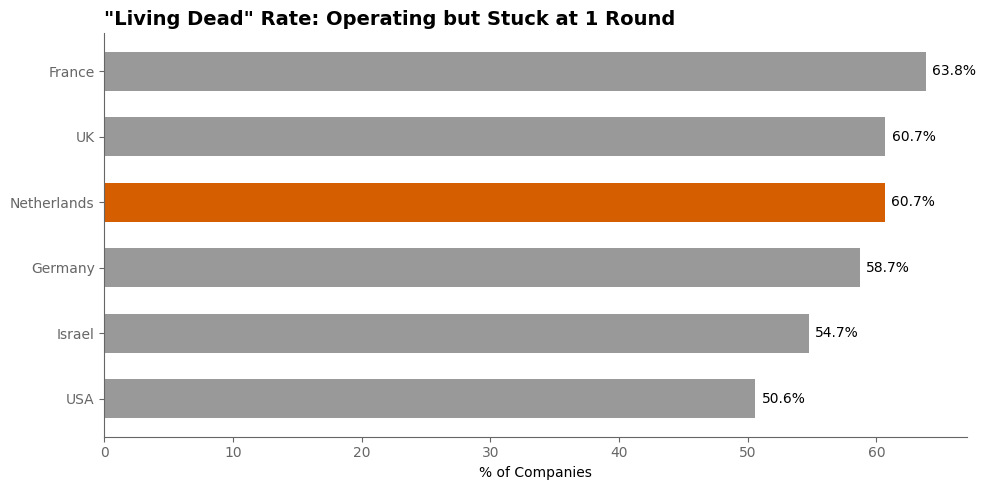


📊 Insight: High 'living dead' rate suggests companies survive but don't grow


In [17]:
# Visualization: Living dead comparison
fig, ax = plt.subplots(figsize=(10, 5))
tufte_style(ax)

countries = living_dead_rate.index.tolist()
rates = living_dead_rate.values
colors = [COLORS['nl'] if c == 'Netherlands' else COLORS['gray'] for c in countries]

bars = ax.barh(countries[::-1], rates[::-1], color=colors[::-1], height=0.6)
for bar, val in zip(bars, rates[::-1]):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', va='center')

ax.set_xlabel('% of Companies')
ax.set_title('"Living Dead" Rate: Operating but Stuck at 1 Round', fontsize=14, fontweight='bold', loc='left')

plt.tight_layout()
plt.savefig('figures/deep_dive_4/living_dead.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Insight: High 'living dead' rate suggests companies survive but don't grow")

---
## Key Findings: Survival Rates

| Finding | Evidence | Policy Implication |
|---------|----------|--------------------|
| **Valley of Death = Seed→A** | NL conversion is 6% vs 15%+ peers | Focus bridge funding here |
| **NL has lower failure rate** | NL fails less than USA | But also exits less = "living dead" |
| **More rounds = better survival** | 3+ rounds has much higher exit rate | Help companies reach 3+ rounds |
| **Sector matters** | Software survives better than Biotech | Sector-specific support needed |
| **"Living dead" problem** | Many NL companies stuck at 1 round | Need to push for growth, not just survival |

**Key insight**: Dutch startups don't die—they just don't grow. The problem is progression, not survival.

---